# A Bayesian regularized artificial neural network for stock market forecasting

## Setup

In [1]:
BACKUP_PATH = "./backup/"

In [2]:
from lib.dataset import Data

from lib.model.optimize import run_one_epoch 
from lib.model.utils import reset_all_weights, generate_bnn_summary
from lib.model.loss import WeightedLoss, mape_loss
from lib.model.plot import training_plot_summary

from lib.backtest import (
    create_backtest_dataset, 
    backtest_plot, 
    generate_price_distribution, 
    plot_predicted_distribution, 
)

In [3]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.axes import Axes

import rich

In [4]:
import torch
import torch.nn as nn
import torchbnn 
from torchsummary import summary

In [5]:
from pickle import load, dump 

In [6]:
def generate_file_name(ticker: str, model_name: str, version: int, extension: str=".pt") -> str: 
    return f"{ticker}-{model_name}-{version}{extension}"

## Financial Data

### Dataset creation

In [7]:
ticker = "GS"

start_date = "2010-01-04"
end_date = "2012-12-31"
window_size = 32

train_prop = .8
ema_n_days = [5, 10] 
d_period = 3

data = Data(ticker, start_date, end_date, window_size, train_prop, ema_n_days, d_period)

[*********************100%***********************]  1 of 1 completed


c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [8]:
print(data)

Data(ticker='GS', start_date='2010-01-04', end_date='2012-12-31', batch_size=32, train_prop=0.8, ema_n_days=[5, 10], d_period=3, target_name='Close+1')


### Basic exploration

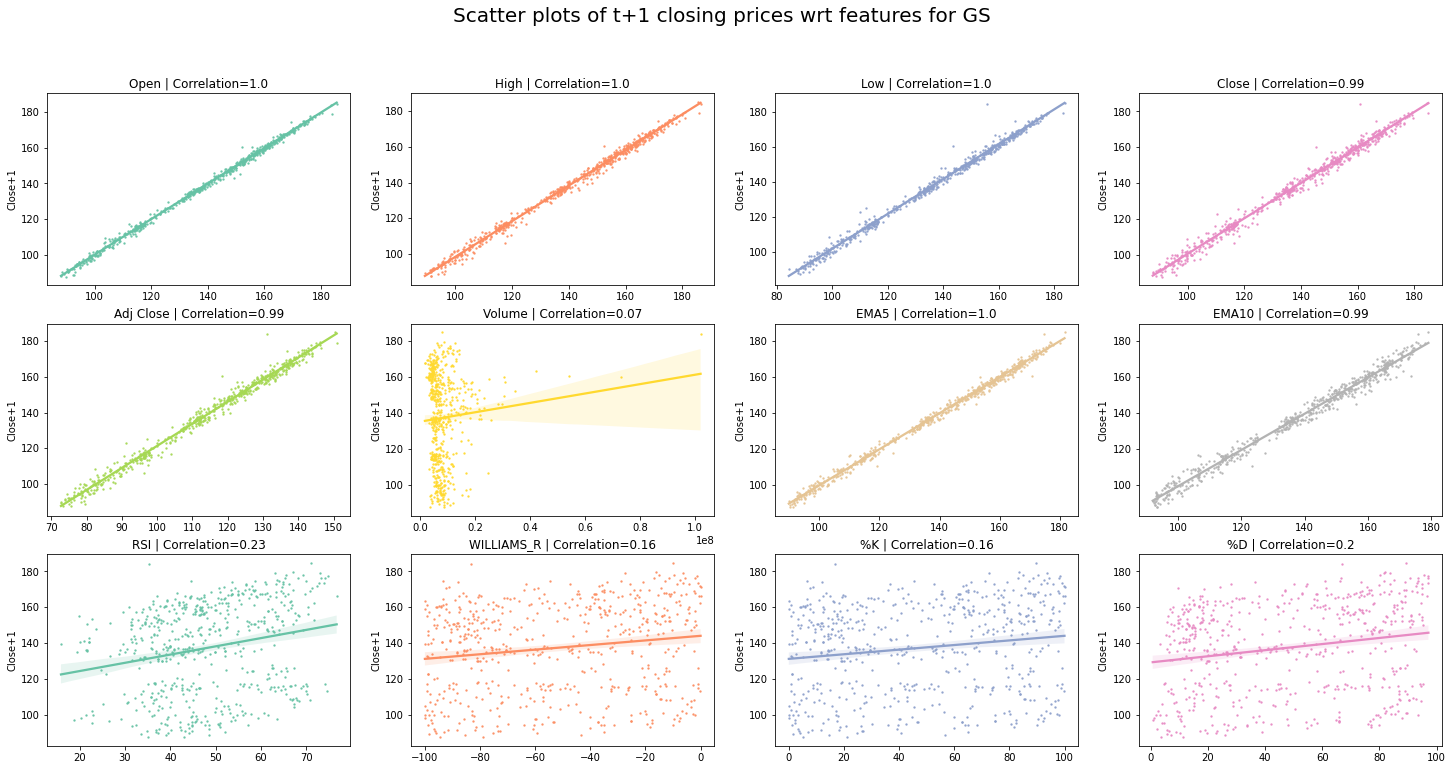

In [26]:
id_vars = data._df_train.columns.drop(labels="Close+1").tolist()
cor_mat = data._df_train.corr()["Close+1"]

ncols = 4
if len(id_vars) % ncols == 0: 
    nrows = len(id_vars) // ncols
else: 
    nrows = len(id_vars) // ncols + 1

colors = sns.color_palette("Set2", n_colors=len(id_vars)) 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 12))
fig.suptitle(f"Scatter plots of t+1 closing prices wrt features for {ticker}", size=20)

def make_regplot(var_name: str, ax: Axes, color: str): 
    sns.regplot(
        data=data._df_train, 
        x=var, 
        y="Close+1", 
        scatter_kws={"s": 2}, 
        color=color, 
        ax=ax)
    ax.set_title(f"{var} | Correlation={round(cor_mat[var], 2)}")
    ax.set_xlabel("")

for var, ax, c in zip(id_vars, axes.flatten(), colors):
    make_regplot(var, ax, c)

## Training & validation

### Frequentist MLP

In [27]:
input_size = 9 
hidden_size = 5
output_size = 1

fnn = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Tanh(),
    nn.Linear(hidden_size, output_size)
)

print(fnn)

Sequential(
  (0): Linear(in_features=9, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=1, bias=True)
)


In [28]:
alpha_init, beta_init = np.log(.5), np.log(.5)
criterion = WeightedLoss(alpha=alpha_init, beta=beta_init, optimize=True)

lr = .01
params = list(fnn.parameters()) + list(criterion.parameters()) 

optimizer = torch.optim.Adam(params=params, lr=lr)
print(optimizer) 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [29]:
results = {"epoch": [], "train_loss": [], "val_loss": [], "val_mape": []}
num_epochs = 100
mape_prev = 0
tol = 1e-4

In [30]:
for epoch in range(num_epochs): 
    train_loss, val_loss, mape = run_one_epoch(fnn, data, criterion, optimizer, epoch, num_epochs)

    results["epoch"].append(epoch)
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["val_mape"].append(mape)

    if epoch > 1:
        mape_diff = np.abs(mape - mape_prev) 
        if mape_diff <= tol:
            print(f"MAPE difference={mape_diff}")
            break 
    
    mape_prev = mape

Epoch [23/100]: 100%|██████████| 19/19 [00:00<00:00, 140.74it/s, train_loss=0.151, val_loss=0.143, val_mape=0.0106]

MAPE difference=9.136079461313784e-05


In [31]:
# save model and criterion as .pt files
model_name = "fnn"
version = "1"

file_name = generate_file_name(ticker, model_name, version)
print(file_name)

torch.save(fnn, BACKUP_PATH+"models/"+file_name)
torch.save(criterion, BACKUP_PATH+"loss/"+file_name)

fnn = torch.load(BACKUP_PATH+"models/"+file_name)
loss = torch.load(BACKUP_PATH+"loss/"+file_name) 

GS-fnn-1.pt


In [32]:
file_name = generate_file_name(ticker, model_name, version, ".pkl")
print(file_name)

# save training results as pickle file
with open(file=BACKUP_PATH+"training/"+file_name, mode="wb") as f: 
    dump(results, f)

# load training results from pickle file
with open(file=BACKUP_PATH+"training/"+file_name, mode="rb") as f: 
    results = load(f)

GS-fnn-1.pkl


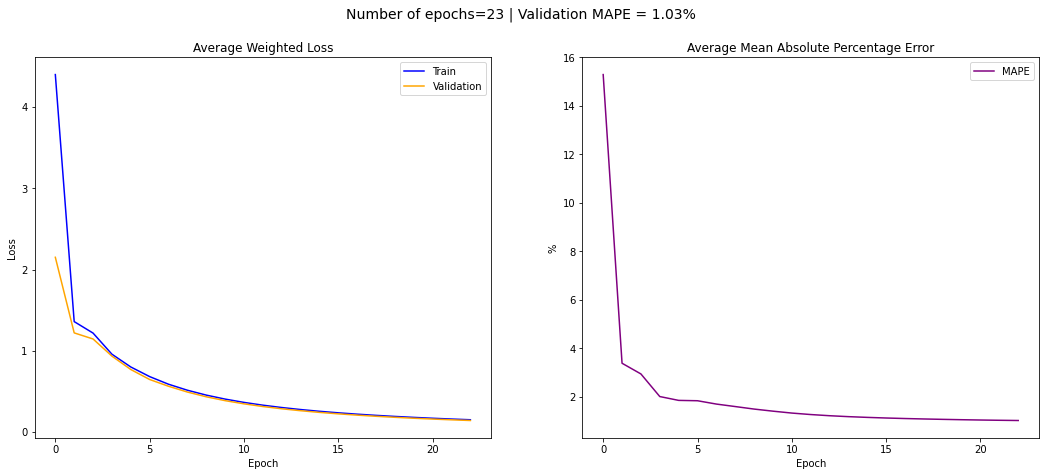

In [33]:
training_plot_summary(results); 

In [18]:
summary(model=fnn, input_size=(1, 9), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [32, 1, 5]              50
              Tanh-2                 [32, 1, 5]               0
            Linear-3                 [32, 1, 1]               6
Total params: 56
Trainable params: 56
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Bayesian MLP

#### Optimization without KL divergence

In [34]:
input_size = 9 
hidden_size = 5
output_size = 1

bnn = nn.Sequential(
    torchbnn.BayesLinear(prior_mu=0, prior_sigma=.1, in_features=input_size, out_features=hidden_size),
    nn.Tanh(),
    torchbnn.BayesLinear(prior_mu=0, prior_sigma=.1, in_features=hidden_size, out_features=output_size)
)

summary_bnn = generate_bnn_summary(bnn)
rich.print(summary_bnn)

                                  Bayesian NN architecture                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)             ┃ Distrbution params        ┃ Tensors                  ┃ Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ BayesLinear(prior_mu=0,  │ weight_mu |               │ torch.Size([5, 9]) |     │ 100     │
│ prior_sigma=0.1,         │ weight_log_sigma |        │ torch.Size([5, 9]) |     │         │
│ in_features=9,           │ bias_mu | bias_log_sigma  │ torch.Size([5]) |        │         │
│ out_features=5,          │                           │ torch.Size([5])          │         │
│ bias=True)               │                           │                          │         │
├──────────────────────────┼───────────────────────────┼──────────────────────────┼─────────┤
│ Tanh()                   │                           │                          │ 0.0     │
├──────────────────────────┼───────────────────────────┼──────────────────────────┼─────────┤
│ BayesLinear(prior_mu=0,  │ weight_mu |               │ torch.Size([1, 5]) |     │ 12      │
│ prior_sigma=0.1,         │ weight_log_sigma |        │ torch.Size([1, 5]) |     │         │
│ in_features=5,           │ bias_mu | bias_log_sigma  │ torch.Size([1]) |        │         │
│ out_features=1,          │                           │ torch.Size([1])          │         │
│ bias=True)               │                           │                          │         │
└──────────────────────────┴───────────────────────────┴──────────────────────────┴─────────┘

In [35]:
alpha_init, beta_init = np.log(.5), np.log(.5)
criterion = WeightedLoss(alpha=alpha_init, beta=beta_init, optimize=True)

In [36]:
lr = .01
params = list(bnn.parameters()) + list(criterion.parameters()) 
optimizer = torch.optim.Adam(params=params, lr=lr)
print(optimizer) 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [37]:
results = {"epoch": [], "train_loss": [], "val_loss": [], "val_mape": []}
num_epochs = 100
mape_prev = 0
tol = 1e-4

In [38]:
for epoch in range(num_epochs): 
    train_loss, val_loss, mape = run_one_epoch(bnn, data, criterion, optimizer, epoch, num_epochs)

    results["epoch"].append(epoch)
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["val_mape"].append(mape)

    if epoch > 1:
        mape_diff = np.abs(mape - mape_prev) 
        if mape_diff <= tol:
            print(f"MAPE difference={mape_diff}")
            break 
    
    mape_prev = mape

Epoch [100/100]: 100%|██████████| 19/19 [00:00<00:00, 103.83it/s, train_loss=1.86, val_loss=1.86, val_mape=0.0402]


In [39]:
# save model and criterion as .pt files
model_name = "bnn"
version = "1"

file_name = generate_file_name(ticker, model_name, version)
print(file_name)

torch.save(bnn, BACKUP_PATH+"models/"+file_name)
torch.save(criterion, BACKUP_PATH+"loss/"+file_name)

bnn = torch.load(BACKUP_PATH+"models/"+file_name)
loss = torch.load(BACKUP_PATH+"loss/"+file_name) 

GS-bnn-1.pt


In [40]:
file_name = generate_file_name(ticker, model_name, version, ".pkl")
print(file_name)

# save training results as pickle file
with open(file=BACKUP_PATH+"training/"+file_name, mode="wb") as f: 
    dump(results, f)

# load training results from pickle file
with open(file=BACKUP_PATH+"training/"+file_name, mode="rb") as f: 
    results = load(f)

GS-bnn-1.pkl


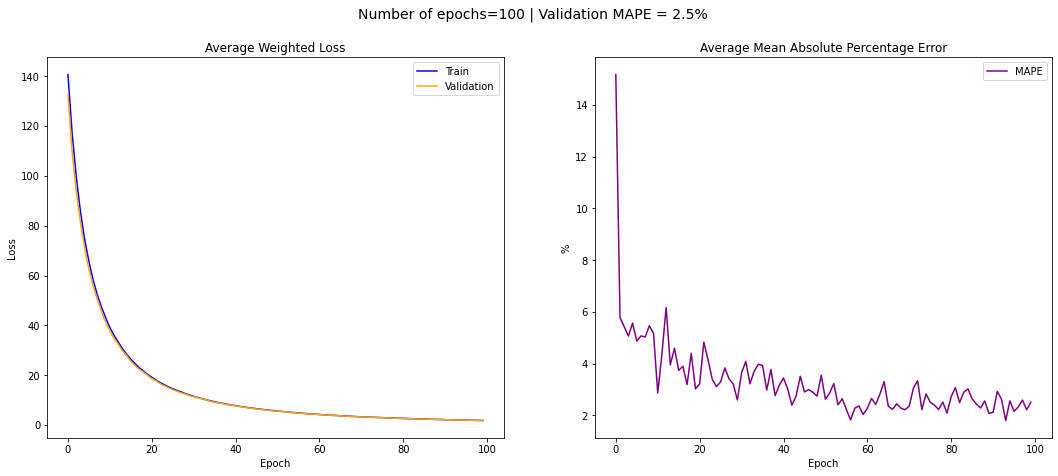

In [41]:
training_plot_summary(results); 

#### Optimization with KL divergence

In [42]:
input_size = 9 
hidden_size = 5
output_size = 1

bnn_kl = nn.Sequential(
    torchbnn.BayesLinear(prior_mu=0, prior_sigma=.1, in_features=input_size, out_features=hidden_size),
    nn.Tanh(),
    torchbnn.BayesLinear(prior_mu=0, prior_sigma=.1, in_features=hidden_size, out_features=output_size)
)

rich.print(generate_bnn_summary(bnn_kl))

                                  Bayesian NN architecture                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)             ┃ Distrbution params        ┃ Tensors                  ┃ Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ BayesLinear(prior_mu=0,  │ weight_mu |               │ torch.Size([5, 9]) |     │ 100     │
│ prior_sigma=0.1,         │ weight_log_sigma |        │ torch.Size([5, 9]) |     │         │
│ in_features=9,           │ bias_mu | bias_log_sigma  │ torch.Size([5]) |        │         │
│ out_features=5,          │                           │ torch.Size([5])          │         │
│ bias=True)               │                           │                          │         │
├──────────────────────────┼───────────────────────────┼──────────────────────────┼─────────┤
│ Tanh()                   │                           │                          │ 0.0     │
├──────────────────────────┼───────────────────────────┼──────────────────────────┼─────────┤
│ BayesLinear(prior_mu=0,  │ weight_mu |               │ torch.Size([1, 5]) |     │ 12      │
│ prior_sigma=0.1,         │ weight_log_sigma |        │ torch.Size([1, 5]) |     │         │
│ in_features=5,           │ bias_mu | bias_log_sigma  │ torch.Size([1]) |        │         │
│ out_features=1,          │                           │ torch.Size([1])          │         │
│ bias=True)               │                           │                          │         │
└──────────────────────────┴───────────────────────────┴──────────────────────────┴─────────┘

In [43]:
criterion = WeightedLoss(alpha=alpha_init, beta=beta_init, kl_weight=.1, optimize=True, optimize_kl=False)

lr = .01
params = list(bnn_kl.parameters()) + list(criterion.parameters()) 
optimizer = torch.optim.Adam(params=params, lr=lr)

In [44]:
results = {"epoch": [], "train_loss": [], "val_loss": [], "val_mape": []}
num_epochs = 100
mape_prev = 0
tol = 1e-4

In [45]:
for epoch in range(num_epochs): 
    train_loss, val_loss, mape = run_one_epoch(bnn_kl, data, criterion, optimizer, epoch, num_epochs)

    results["epoch"].append(epoch)
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["val_mape"].append(mape)

    if epoch > 1:
        mape_diff = np.abs(mape - mape_prev) 
        if mape_diff <= tol:
            print(f"MAPE difference={mape_diff}")
            break 
    
    mape_prev = mape

Epoch [92/100]: 100%|██████████| 19/19 [00:00<00:00, 69.33it/s, train_loss=2.08, val_loss=2.11, val_mape=0.0492]

MAPE difference=6.422866135835648e-06


In [46]:
model_name = "bnn_kl"
version = "1"

file_name = generate_file_name(ticker, model_name, version)
print(file_name)

torch.save(bnn_kl, BACKUP_PATH+"models/"+file_name)
torch.save(criterion, BACKUP_PATH+"loss/"+file_name)

bnn = torch.load(BACKUP_PATH+"models/"+file_name)
loss = torch.load(BACKUP_PATH+"loss/"+file_name) 

GS-bnn_kl-1.pt


In [47]:
file_name = generate_file_name(ticker, model_name, version, ".pkl")
print(file_name)

# save training results as pickle file
with open(file=BACKUP_PATH+"training/"+file_name, mode="wb") as f: 
    dump(results, f)

# load training results from pickle file
with open(file=BACKUP_PATH+"training/"+file_name, mode="rb") as f: 
    results = load(f)

GS-bnn_kl-1.pkl


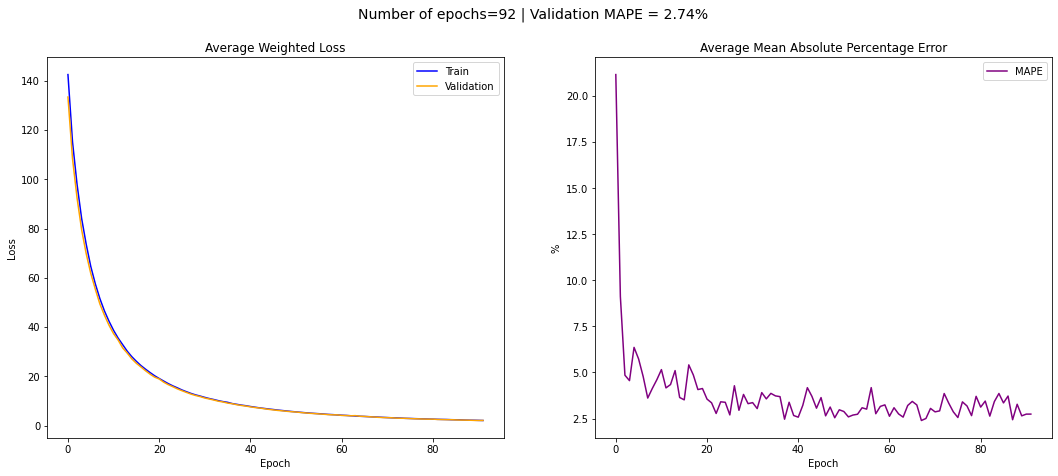

In [48]:
training_plot_summary(results); 

## Backtest

In [49]:
model_names = ("fnn", "bnn", "bnn_kl")
version = "1"

files = [f"{ticker}-{m}-{version}" for m in model_names]

models = {
    m: torch.load(BACKUP_PATH+"models/"+f+".pt")
    for m, f in zip(model_names, files) 
}

### Frequentist MLP

**Training set**

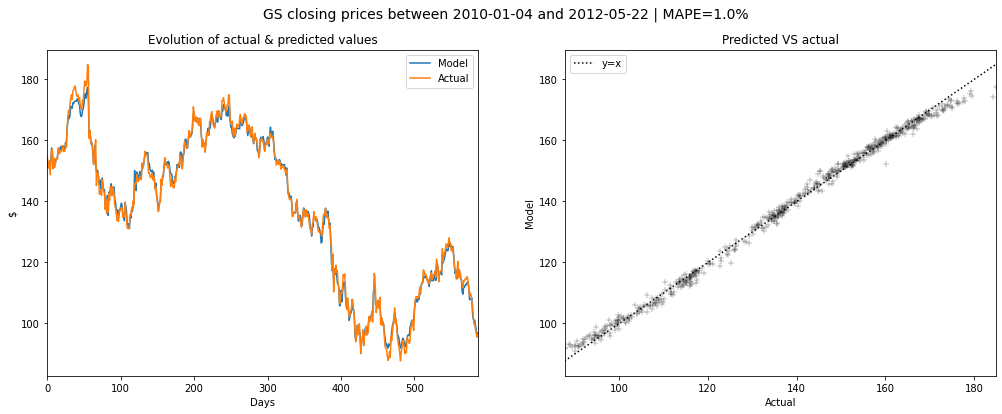

In [50]:
df_backtest, mape = create_backtest_dataset(data=data, model=models["fnn"], training=True)
backtest_plot(ticker, df_backtest, mape, data.train_period)

**Test set**

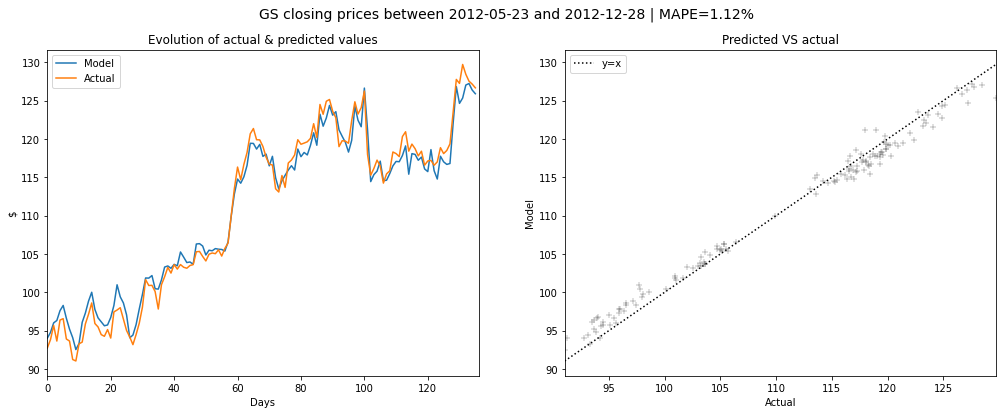

In [51]:
df_backtest, mape = create_backtest_dataset(data=data, model=models["fnn"], training=False)
backtest_plot(ticker, df_backtest, mape, data.test_period)

### Bayesian MLP

#### Without KL divergence

**Training set**

In [52]:
# generate 100 predictions per day in the test set 
preds_bnn_tr = generate_price_distribution(data, models["bnn"], training=True)

# take the daily average 
avg_preds_bnn_tr = preds_bnn_tr.T.mean(axis=1).values.reshape(-1, 1)

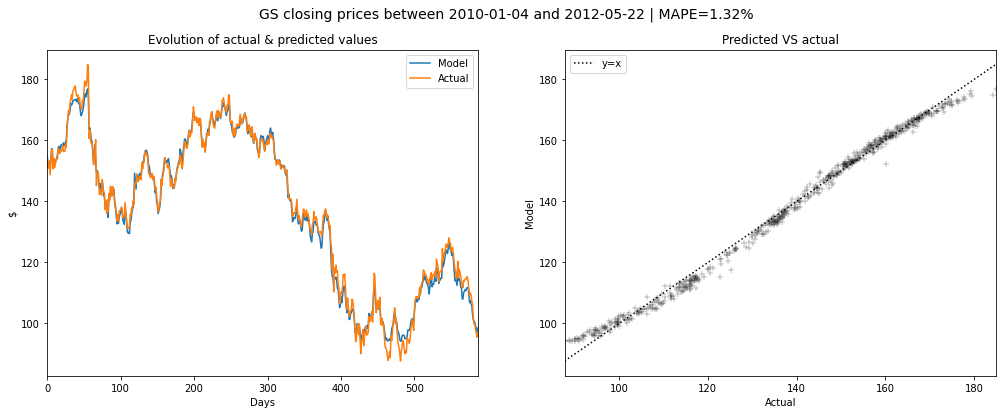

In [53]:
df_backtest, mape = create_backtest_dataset(data, preds=avg_preds_bnn_tr, training=True)
backtest_plot(ticker, df_backtest, mape, data.train_period)

**Test set** 

In [19]:
# generate 100 predictions per day in the test set 
# preds_bnn_te = generate_price_distribution(data, models["bnn"], training=False)

# save average predicted prices to pickle
model = "bnn"
version = "1"

file_name = generate_file_name(ticker, model, version, extension=".pkl")
print(file_name)

# with open(file=BACKUP_PATH+"preds/"+file_name, mode="wb") as f: 
#     dump(preds_bnn_te, f)

with open(file=BACKUP_PATH+"preds/"+file_name, mode="rb") as f: 
    preds_bnn_te = load(f)

MSFT-bnn-1.pkl


In [56]:
# take the daily average 
avg_preds_bnn_te = preds_bnn_te.T.mean(axis=1).values.reshape(-1, 1)

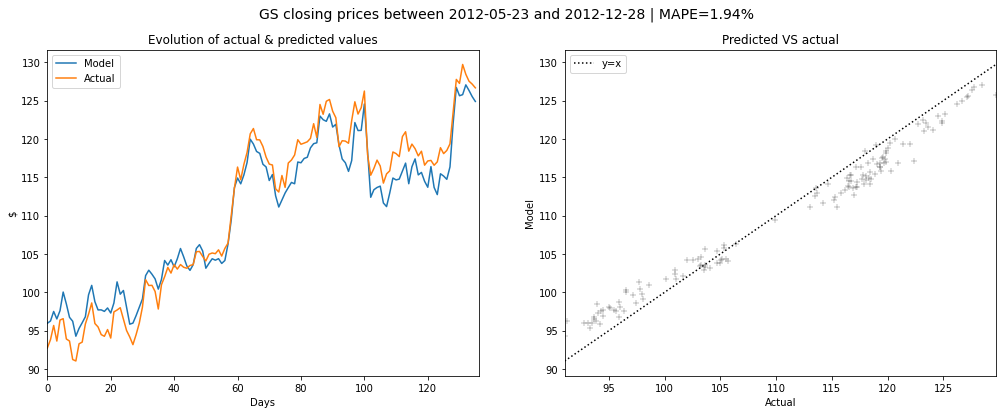

In [57]:
df_backtest, mape = create_backtest_dataset(data=data, preds=avg_preds_bnn_te, training=False)
backtest_plot(ticker, df_backtest, mape, data.test_period)

#### With KL divergence

**Training set**

In [58]:
# generate 100 predictions per day in the test set 
preds_bnn_kl_tr = generate_price_distribution(data, models["bnn_kl"], training=True)

# take the daily average 
avg_preds_bnn_kl_tr = preds_bnn_kl_tr.T.mean(axis=1).values.reshape(-1, 1)

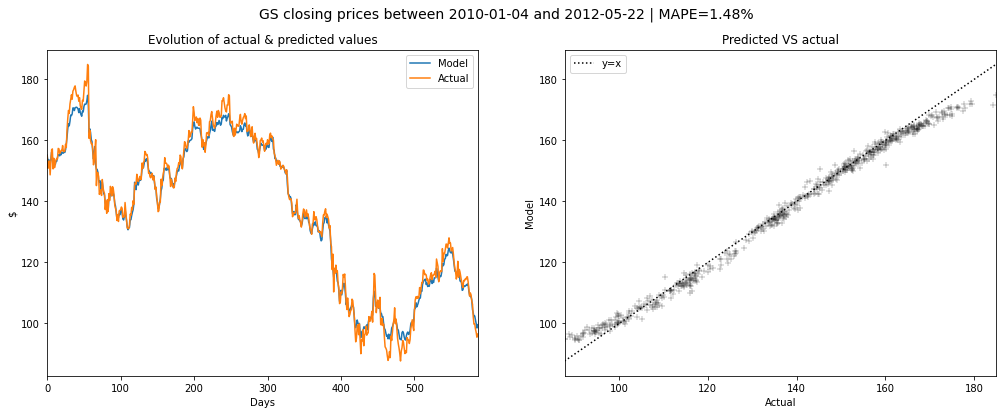

In [59]:
df_backtest, mape = create_backtest_dataset(data, preds=avg_preds_bnn_kl_tr, training=True)
backtest_plot(ticker, df_backtest, mape, data.train_period)

**Test set**

In [16]:
# generate 100 predictions per day in the test set 
# preds_bnn_kl_te = generate_price_distribution(data, models["bnn_kl"], training=False)

# save average predicted prices to pickle
model = "bnn_kl"
version = "1"

file_name = generate_file_name(ticker, model, version, extension=".pkl")
print(file_name)

# with open(file=BACKUP_PATH+"preds/"+file_name, mode="wb") as f: 
#     dump(preds_bnn_kl_te, f)

with open(file=BACKUP_PATH+"preds/"+file_name, mode="rb") as f: 
    preds_bnn_kl_te = load(f)

MSFT-bnn_kl-1.pkl


In [61]:
# take the daily average 
avg_preds_bnn_kl_te = preds_bnn_kl_te.T.mean(axis=1).values.reshape(-1, 1)

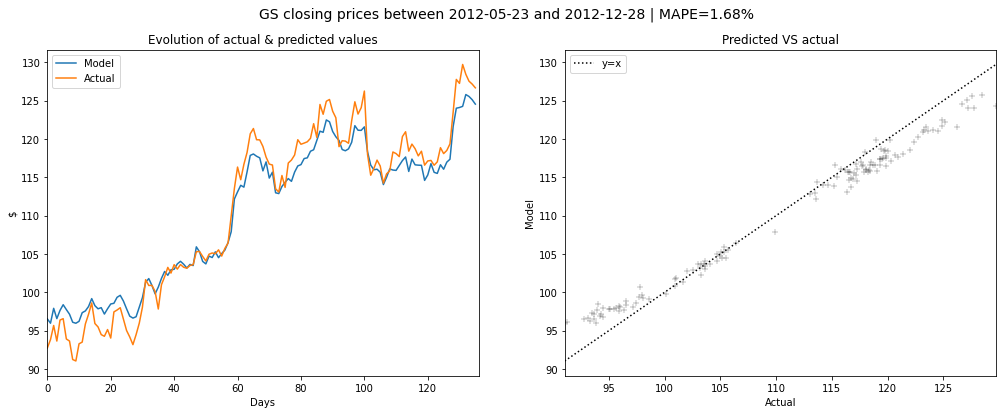

In [62]:
df_backtest, mape = create_backtest_dataset(data=data, preds=avg_preds_bnn_kl_te, training=False)
backtest_plot(ticker, df_backtest, mape, data.test_period)

### Uncertainty measurement through simulations

In [63]:
date = "2012-06-19"

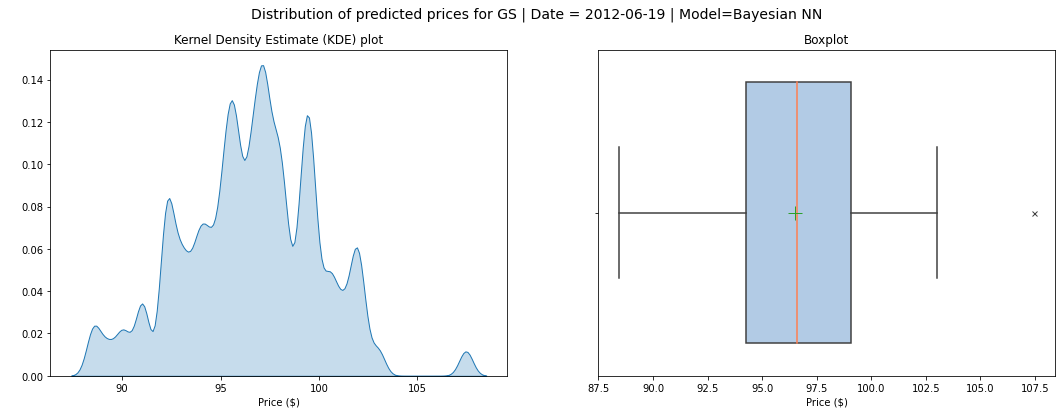

In [64]:
plot_predicted_distribution(preds_bnn_te, ticker, date, "Bayesian NN")

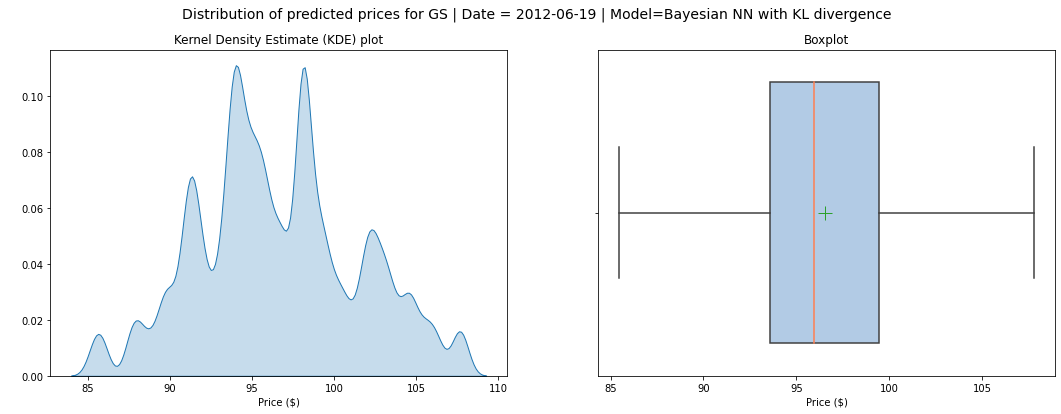

In [65]:
plot_predicted_distribution(preds_bnn_kl_te, ticker, date, model_name="Bayesian NN with KL divergence")